In [636]:
import numpy as np
import pandas as pd
import seaborn as sns
import json
import matplotlib.pyplot as plt
import datetime as dt
from matplotlib.pyplot import figure, gca
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# Part 1) Exploratory Data Analysis

In [339]:
logins = pd.read_json('logins.json')

In [340]:
logins

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21
...,...
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38


In [341]:
# Aggregate the login times to 15 minutes intervals as well as count how many logins were within the intervales

logins_df = logins.groupby(logins.login_time.dt.floor('15Min')).size().to_frame()

In [342]:
logins_df

,0
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1
...,...
1970-04-13 17:45:00,5
1970-04-13 18:00:00,5
1970-04-13 18:15:00,2


In [343]:
# Rename columns appropriately

logins_df.rename(columns= {0: 'login_count'}, inplace= True)

In [345]:
# Create a new column with an isolated timestamp

logins_df['time'] = logins_df.index.time

In [346]:
logins_df.head()

,login_count,time
login_time,,
1970-01-01 20:00:00,2,20:00:00
1970-01-01 20:15:00,6,20:15:00
1970-01-01 20:30:00,9,20:30:00
1970-01-01 20:45:00,7,20:45:00
1970-01-01 21:00:00,1,21:00:00


In [347]:
# Order the rows by time of day, starting from midnight (or 00:00:00)

logins_df.sort_values(by= 'time', ascending= True, inplace= True)

In [348]:
# Aggregate all the counts of the same time interval

logins_15m = logins_df.groupby('time')['login_count'].sum().to_frame()

In [349]:
logins_15m.head()

,login_count
time,
00:00:00,1439
00:15:00,1547
00:30:00,1525
00:45:00,1482
01:00:00,1549


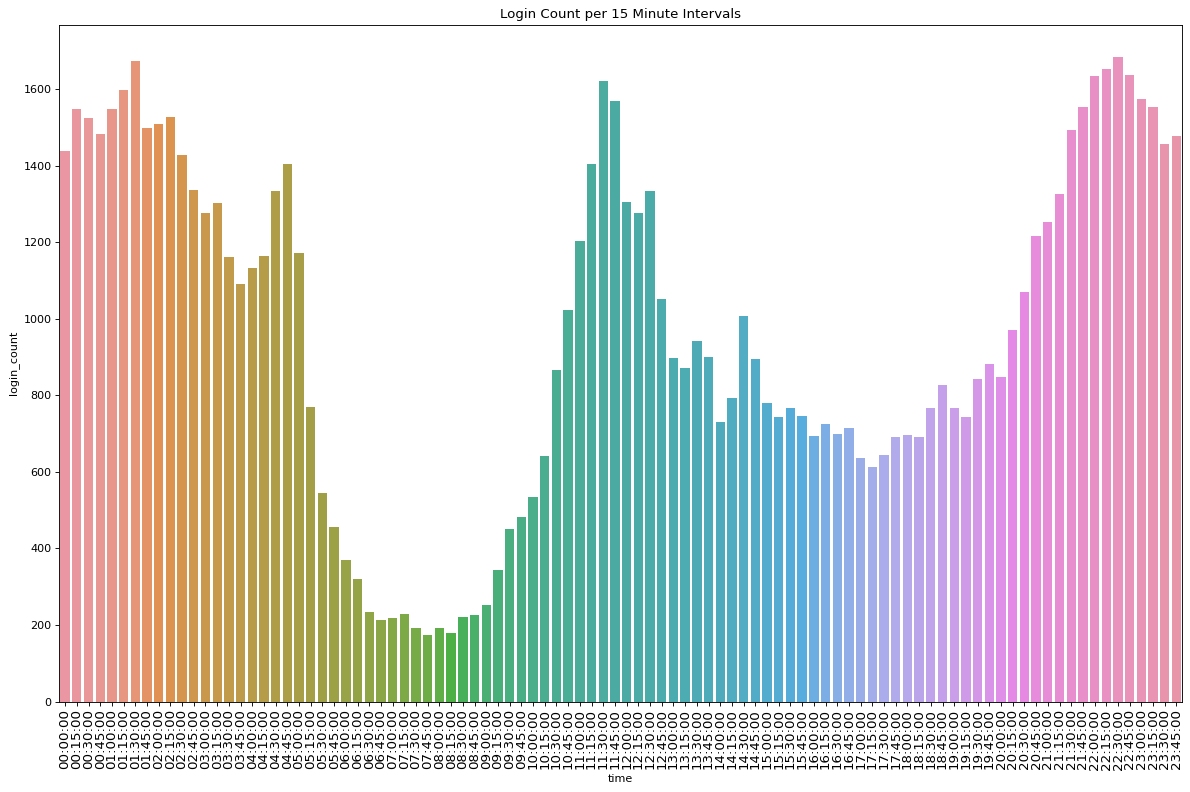

In [350]:
# Visualize the data with respect to 15 minute time intervals (This graph should be used as reference to look at the data more
# microscopicolly. The chart below this one will be a more holistic and readable representation.)

_ = figure(num=None, figsize=(15, 10), dpi= 80)
_ = sns.barplot(x= logins_15m.index, y= 'login_count',data= logins_15m, ci= None)
ax = gca()
_ = plt.xticks(rotation= 90)
_ = ax.xaxis.set_tick_params(labelsize= 12)
_ = plt.title('Login Count per 15 Minute Intervals')
_ = plt.tight_layout()
_ = plt.show()

In [351]:
# Repeat the steps above but this time the data will be represented in 1 hour intervals

logins_1h = logins.groupby(logins.login_time.dt.floor('1H')).size().to_frame()

In [352]:
logins_1h.rename(columns= {0: 'login_count'}, inplace= True)

In [353]:
logins_1h['time'] = logins_1h.index.time

In [354]:
logins_1h = logins_1h.groupby('time')['login_count'].sum().to_frame()

In [355]:
logins_1h.head(3)

,login_count
time,
00:00:00,5993
01:00:00,6317
02:00:00,5800


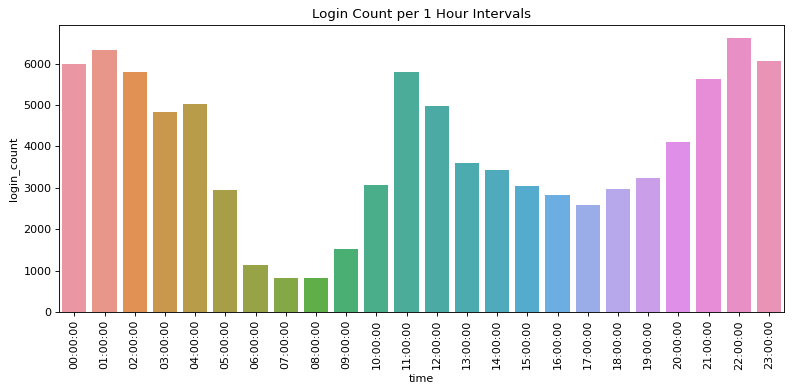

In [356]:
_ = figure(num=None, figsize=(10, 5), dpi= 80)
_ = sns.barplot(x= logins_1h.index, y= 'login_count',data= logins_1h, ci= None)
ax = gca()
_ = plt.xticks(rotation= 90)
_ = plt.title('Login Count per 1 Hour Intervals')
_ = plt.tight_layout()
_ = plt.show()

Based on both the distributions shown above with the 15 minute and 1 hour time intervals for the login times, it appears that business generally increases from approximately 9 PM to 4 AM, and booms back again during lunch hours from approximately 11 AM to 1 PM. Both having lull periods at from approximately 7 to 9 AM, and 5 PM.

In [357]:
# Repeat the steps above but this time the calendar days are appropriately represent by days of the week

logins_daily = logins.groupby(logins.login_time.dt.floor('D')).size().to_frame()

In [358]:
logins_daily['DaysOfWeek'] = logins_daily.index.day_name()

In [359]:
logins_daily.rename(columns= {0: 'login_count'}, inplace= True)

In [360]:
logins_daily = logins_daily.groupby('DaysOfWeek')['login_count'].sum().to_frame()

In [361]:
logins_daily.head(1)

,login_count
DaysOfWeek,
Friday,15208


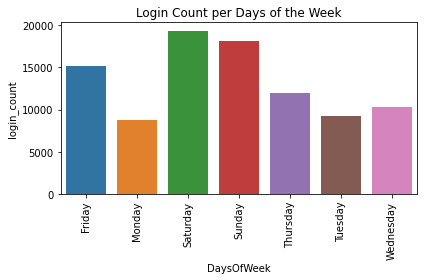

In [362]:
_ = sns.barplot(x= logins_daily.index, y= 'login_count', data= logins_daily, ci= None)
ax = gca()
_ = plt.xticks(rotation= 90)
_ = plt.title('Login Count per Days of the Week')
_ = plt.tight_layout()
_ = plt.show()

The distribution above shows that the business is most active during he weekends and least active on Mondays, which makes 
sense - no one likes Mondays.

In [368]:
logins_15m.describe(), logins_1h.describe(), logins_daily.describe()

(       login_count
 count    96.000000
 mean    970.229167
 std     455.485640
 min     175.000000
 25%     690.750000
 50%     899.500000
 75%    1404.000000
 max    1684.000000,
        login_count
 count    24.000000
 mean   3880.916667
 std    1803.481559
 min     815.000000
 25%    2916.750000
 50%    3518.500000
 75%    5667.000000
 max    6607.000000,
         login_count
 count      7.000000
 mean   13306.000000
 std     4303.516082
 min     8823.000000
 25%     9803.500000
 50%    11960.000000
 75%    16687.500000
 max    19377.000000)

As shown in the summary statistics above, the mean for the 15 min, 1 hour and weekday intervals were approximately 970, 3881 and 13306, respectively. The means of 15 minute and 1 hour intervals are intuitively correlated, meaning that multiplying 970 * 4 (since there are four 15 minutes in one hour) will give the mean of approximately 3881 as shown above. That's not the case with the daily cycle since each day had more volatility, depending on which day of the week it was.

# Part 2) Experiment and Metrics Design

Question 1: In order to measure the success of this experiment, I would look at time in which the toll ticket was given to the driver, in conjunction to the time the driver was active within the service app. This will ensure that the drivers who are looking for reimbursement of their toll ticket during "active" hours are receiving it accordingly, as well as avoiding any exploitations or foul play within the system.

Question 2:
    A) Considering the drivers reside in either one side of the river or the other, they will have to be reimbursed twice (since it's a two way toll). Therefore, we can get enough information from drivers of each side of the river to see how well the experiment is working.
    B-C) I would use t-test as its a good statiscal test to observe how two groups differ from each other. I would then create a hypothesis to further deduce whether or not the experiment is significant.
                Null Hypothesis: The true difference of the mean of tickets acquired by driver partners of each city differs from 0
                Alternate: The true difference of the mean of tickets acquired by driver partners of each city is is equal to 0
         
         If the Null Hypthosesis is true, that means that in one city there are more people utilizing the toll reimbursement program. If the Alternate is true, it either means that both the cities aren't utilizing the toll reimbursement program or that they are utilizing it equally (this can easily be dilineated by looking to see if drivers have turned in toll tickets.)
         
         A caveat to help push this may be to add a surge during the initial phases of the implementation. Then once the drivers have adjusted and became more accepting that driving across a bridge is part of the job description, slowly remove those surges.

# Part 3) Predictive Modeling

In [594]:
trip_df = pd.read_json('ultimate_data_challenge.json')

In [595]:
trip_df

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5


In [596]:
trip_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [597]:
# Convert these columns to datetime

trip_df['signup_date'] = pd.to_datetime(trip_df.signup_date)
trip_df['last_trip_date'] = pd.to_datetime(trip_df.last_trip_date)

In [598]:
# Identify when were the most recent trips. I'm going to use that as reference to seeing which users were active in the past 30 
# days since July 1st.

trip_df = trip_df.sort_values('last_trip_date', ascending= False)

In [599]:
# Check for any missing data

print(trip_df.isnull().any())
print(trip_df.isnull().any().count())

city                      False
trips_in_first_30_days    False
signup_date               False
avg_rating_of_driver       True
avg_surge                 False
last_trip_date            False
phone                      True
surge_pct                 False
ultimate_black_user       False
weekday_pct               False
avg_dist                  False
avg_rating_by_driver       True
dtype: bool
12


In [600]:
# I've decided to drop all rows with missing values.
# Considering that with the data provided, there isn't an appropriate way to impute new values to the already missing values.

trip_df = trip_df.dropna()

In [601]:
# Essentially we are making a new column for users that are active within the past 30 days of the more recent login time

trip_df['days_since_login'] = ((trip_df.last_trip_date.max() - trip_df.last_trip_date) / np.timedelta64(1, "D"))
trip_df['days_since_login'] = trip_df.days_since_login.astype(int)
trip_df['active_user'] = trip_df.days_since_login.apply(lambda x: x <= 30)

In [602]:
# Check what is the percentage of active users within the dataframe

print(round(((trip_df.active_user.loc[trip_df['active_user'] == True].count() / trip_df.shape[0]) * 100), 1), '%')

41.1 %


Question 1: Approximately 41.1 percent of the users within the dataframe are considered "retained".

In [603]:
# On average the users in this data frame have been "inactive" for approximately 73 days. On the bright side, they have received
# an average rating of 4.6 out of 5. The costumers seem to generally enjoy the drivers of this service

trip_df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,days_since_login
count,41445.000000,41445.000000,41445.000000,41445.000000,41445.000000,41445.000000,41445.000000,41445.000000
mean,2.609675,4.601720,1.073822,8.898709,61.254897,5.460046,4.776446,67.423405
std,4.059336,0.616104,0.198747,18.322061,34.813848,5.145174,0.404606,60.798925
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,4.300000,1.000000,0.000000,37.500000,2.420000,4.700000,11.000000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.780000,5.000000,46.000000
75%,3.000000,5.000000,1.070000,11.100000,100.000000,6.490000,5.000000,127.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,79.690000,5.000000,181.000000


In [604]:
# We shall now create or long_term user column which will be used as our label in our machine learning model

trip_df['months_in_service'] = ((trip_df.last_trip_date - trip_df.signup_date) / np.timedelta64(1, "M"))
trip_df['months_in_service'] = trip_df.months_in_service.astype(int)
trip_df['longterm_user'] = trip_df.months_in_service.apply(lambda x: x >= 5)

In [605]:
trip_df.sample(8)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,days_since_login,active_user,months_in_service,longterm_user
6829,Astapor,2,2014-01-06,5.0,1.00,2014-01-15,iPhone,0.0,True,50.0,5.55,5.0,167,False,0,False
46669,Astapor,1,2014-01-07,5.0,1.00,2014-04-04,Android,0.0,False,100.0,0.85,5.0,88,False,2,False
18198,Winterfell,2,2014-01-18,4.0,1.00,2014-01-19,Android,0.0,True,0.0,11.13,5.0,163,False,0,False
18013,Astapor,0,2014-01-05,4.5,1.25,2014-05-11,Android,25.0,True,25.0,3.37,5.0,51,False,4,False
32591,Astapor,8,2014-01-19,5.0,1.06,2014-02-13,iPhone,12.5,False,62.5,6.43,4.9,138,False,0,False
7482,Astapor,1,2014-01-30,5.0,1.38,2014-05-03,Android,30.0,True,90.0,4.01,5.0,59,False,3,False
22981,Astapor,1,2014-01-29,5.0,1.50,2014-05-31,iPhone,30.0,False,30.0,4.23,4.8,31,False,4,False
35095,Astapor,2,2014-01-22,4.7,1.17,2014-04-05,iPhone,33.3,True,100.0,8.64,5.0,87,False,2,False


In [624]:
# We'll create our machine learning model using logistic regression

x = trip_df.drop(columns = ['longterm_user','signup_date', 'months_in_service', 'phone', 'last_trip_date', 'city'], axis= 1)
y = trip_df.longterm_user

x = pd.get_dummies(x)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size= 0.3, random_state= 123)

In [646]:
# Make a gridsearch to hypertune parameters

param_RFC = {'n_estimators': [100, 200, 300], 'max_depth': [10, 20, 30]}
gs_RFC = GridSearchCV(estimator= RandomForestClassifier(), 
                      param_grid= param_RFC, 
                      cv= StratifiedKFold(n_splits = 5),  # This helps distribute the imbalanced labels proportionally in each fold
                      scoring='accuracy')

In [647]:
# Fit the model to the data and predict on the "unseen" data


gs_RFC.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                         

In [650]:
# Put the results in dataframe format

grid_rfc = pd.DataFrame(gs_RFC.cv_results_)
print(gs_RFC.best_params_, gs_RFC.best_score_)

{'max_depth': 10, 'n_estimators': 100} 0.9059321858209891


In [657]:
grid_rfc

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.062640,0.028530,0.055883,0.005276,10,100,"{'max_depth': 10, 'n_estimators': 100}",0.907289,0.903137,0.908307,0.906239,0.904688,0.905932,0.001841,1
1,2.083801,0.059937,0.101636,0.003229,10,200,"{'max_depth': 10, 'n_estimators': 200}",0.907806,0.903137,0.907273,0.906412,0.903309,0.905587,0.001982,3
2,3.096823,0.062001,0.151630,0.003049,10,300,"{'max_depth': 10, 'n_estimators': 300}",0.909013,0.902620,0.907446,0.905895,0.903482,0.905691,0.002386,2
3,1.369134,0.027059,0.068827,0.001105,20,100,"{'max_depth': 20, 'n_estimators': 100}",0.905394,0.901069,0.901069,0.902620,0.899862,0.902003,0.001908,9
4,2.808961,0.056595,0.138975,0.002832,20,200,"{'max_depth': 20, 'n_estimators': 200}",0.906428,0.902964,0.904343,0.903137,0.900379,0.903450,0.001971,4
5,4.156635,0.045280,0.215271,0.010458,20,300,"{'max_depth': 20, 'n_estimators': 300}",0.906945,0.901758,0.901930,0.903826,0.901413,0.903175,0.002064,5
6,1.444172,0.059573,0.072406,0.002793,30,100,"{'max_depth': 30, 'n_estimators': 100}",0.904187,0.901930,0.902964,0.902447,0.899173,0.902140,0.001662,8
7,2.864539,0.059839,0.142600,0.004733,30,200,"{'max_depth': 30, 'n_estimators': 200}",0.906428,0.902792,0.902620,0.900552,0.901241,0.902726,0.002032,7
8,4.195754,0.046038,0.210821,0.003375,30,300,"{'max_depth': 30, 'n_estimators': 300}",0.906083,0.902447,0.903309,0.901930,0.901758,0.903106,0.001583,6


I chose random forest classifier because it treats every entry of each driver independently as it primes each tree to the features taking into consideration. Afterwards, it all comes together into a whole decision making system. I thought this approach would be best as it intertwines a broader amount of data into the process. Originally attempted logistic regression but opted for RandomForestClassifier due to the reasons explained above.

I also chose accuracy as my metric for my machine learning model, as I felt that both precision and recall were equally important (or unimportant?) due to the fact that a wrong prediction, such as false positives, is equally as non detrimental as false negatives.

In [626]:
metrics.accuracy_score(y_test, y_pred) # This was ran with the basic non-hyperparameter tuned RFC model

0.9025253337622647

In [651]:
featureImp = pd.Series(rfc.feature_importances_, index = x.columns.tolist()).sort_values(ascending = False)
featureImp

days_since_login          0.448612
active_user               0.201491
avg_dist                  0.091150
weekday_pct               0.058581
avg_rating_by_driver      0.043367
surge_pct                 0.040763
trips_in_first_30_days    0.037457
avg_rating_of_driver      0.036706
avg_surge                 0.030754
ultimate_black_user       0.011118
dtype: float64

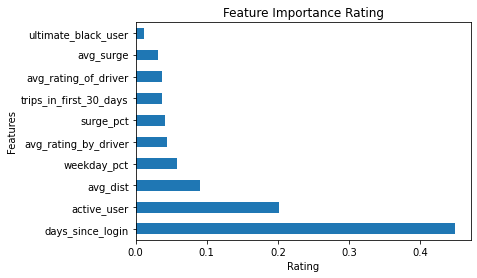

In [652]:
featureImp.plot(kind= 'barh')
_ = plt.title('Feature Importance Rating')
_ = plt.xlabel('Rating')
_ = plt.ylabel('Features')

It appears that if the user has been active recently, the model identified it as an important feature to driver retention. This intuitively makes sense and is pretty obvious. It appears as the average distance driven by the driver is a big factor to rentention. Perhaps a marketing campaign can help spread the word of the driving services, which in turn can bring in more costumers and increase average distance as get existing drivers back to driving and becoming reinstated as acitve members